# New York City Bedbug Data - Modelling

In this notebook, I take the processed data produced by the notebook dedicated to cleaning and transforming the NYC bedbug infestation data, and briefly try out some data analysis on it. I had hoped that this would be a useful method to practise using scikit-learn and get some interesting patterns. However, I was unable to pull any meaningful patterns out of the data. Nonetheless, I have posted this notebook as a brief demonstration of my grasp of some essential methods.

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

from IPython.display import display, HTML, Markdown

# prevent RadiusNearestNeighbors from printing warnings about points with not usable neighbors
import warnings
warnings.filterwarnings('ignore')

Firstly, pull in the processed data and do a few transformations on it.

In [2]:
building_records = pd.read_csv('NYC Bedbugs processed.csv',dtype={'BIN':str,'Latitude':str,'Longitude':str})

# pull out the bits we are interested in, and calculate rates of infestation, eradication, and reinfestation
data = building_records[['LAT','LON','YEAR','BIN']].copy()
data['INF_RATE'] = building_records['#INF']/building_records['#TOT']
data['ERA_RATE'] = (building_records['#ERA']/building_records['#INF']).fillna(0)
data['REI_RATE'] = (building_records['#REI']/building_records['#ERA']).fillna(0)

#  We convert the latitude and longitude to meters from the point 40.70N 73.92W (which seems to be the
# approximate geographic centre of NYC). The simple affine transformation used below is sufficiently accurate
# for our purposes, on the scale of NYC the error introduced is less than 1%
data['LAT'] = (data['LAT']-40.70)*(111195)
data['LON'] = (data['LON']+73.92)*(50850)

# take a peek at the data
data.head()

,LAT,LON,YEAR,BIN,INF_RATE,ERA_RATE,REI_RATE
0,3077.877600,-1476.17550,2020,3065755,0.0,0.0,0.0
1,-9636.937065,-3777.69735,2021,3159693,0.0,0.0,0.0
2,-1718.518725,-1305.16695,2022,3051701,0.0,0.0,0.0
3,322.799085,900.75690,2020,4083378,0.0,0.0,0.0
4,-4876.234335,843.95745,2022,3388522,0.0,0.0,0.0


## Nearest Neighbors Methods

My initial hope for this notebook was that Nearest Neighbor algorithms, using geographic distance, might yield a good predictive model for the infestation rate in a property. In particular the data is 2-dimensional, and low dimensions can do well with Nearest Neighbors. I have used scikit-learn's ``KNeighborsRegressor`` and ``RadiusNeighborsRegressor`` with various parameters, and I have seperated the data by year for these models. I have used R<sup>2</sup> (coefficient of determination) as a metric of performance, with the scores presented in a table.

In [3]:
# We'll split the data by year of filing and train Nearest Neighbor models on each year's data.
# This feels sensible, as I think we would want proximity in time as well as distance to see an effect
data_by_year = {year:data[data['YEAR']==year] for year in [2018,2019,2020,2021,2022]}
for year in data_by_year:
    print(f"{year}: {data_by_year[year].shape[0]} records")

2018: 33133 records
2019: 30618 records
2020: 86467 records
2021: 86667 records
2022: 93597 records


In [4]:
# choose which combinations of parameters to try out in our models
args_knn = itertools.product([5,10,20],['distance','uniform'])
args_rnn = itertools.product([50,100,300],['distance','uniform'])

# set up data to loop over the various different models
estimators_and_descs = []
for args in args_knn:
    knn = KNeighborsRegressor(n_neighbors=args[0],weights=args[1])
    desc = f"[KNN, {args[0]}, {args[1]}]"
    estimators_and_descs.append([knn,desc])
for args in args_rnn:
    rnn = RadiusNeighborsRegressor(radius=args[0],weights=args[1])
    desc = f"[RNN, {args[0]}, {args[1]}]"
    estimators_and_descs.append([rnn,desc])

# loop over the various datasets and models, recording the R^2 score for each
rows = [] # will be used to make the rows of a table of results
for year,estimator_and_desc in itertools.product(data_by_year.keys(),estimators_and_descs):
    estimator,desc = estimator_and_desc
    
    df = data_by_year[year]
    X = df[['LAT','LON']].to_numpy()
    y = df['INF_RATE'].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    
    #RadiusNeighborsRegressor can return NaN when a test vector has no neighbors in range, we'll just ignore these
    nan_mask = np.isnan(y_pred)
    y_pred = y_pred[~nan_mask]
    y_test = y_test[~nan_mask]
    r2 = r2_score(y_test,y_pred)

    rows.append([desc,year,r2])

# display the results in a table, sorted by R^2 score
results_df = pd.DataFrame(rows,columns=['Model','Year','R2'])
rounded_results_df = results_df.round(decimals=4)
rounded_results_df = rounded_results_df.set_index('Model')
rounded_results_df = rounded_results_df.sort_values('R2')
display(Markdown('### R<sup>2</sup> scores'))
display(rounded_results_df)

### R<sup>2</sup> scores

,Year,R2
Model,,
"[RNN, 50, distance]",2018,-0.5455
"[RNN, 50, uniform]",2019,-0.5384
"[RNN, 50, distance]",2020,-0.5282
"[RNN, 50, distance]",2019,-0.4951
"[RNN, 50, distance]",2022,-0.3775
"[KNN, 5, uniform]",2021,-0.3624
"[RNN, 100, distance]",2021,-0.3415
"[KNN, 5, distance]",2021,-0.2917
"[KNN, 5, distance]",2019,-0.2804


Ok, so we can fairly summarise that table as "NOPE!". Let's try something else.

## Year-to-year changes for buildings

So my next idea is to take every instance where we have data for the same building in consecutive years and make a dataframe where each row records the rate of infestation, eradication, and reinfestation in a building in two consecutive years. We can then do scatter plots of each combination of a rate from the first year and a rate from the second year, and look for patterns.

In [5]:
# we don't need geographical positions anymore
data = data.drop(['LAT','LON'],axis=1)
data.head()

,YEAR,BIN,INF_RATE,ERA_RATE,REI_RATE
0,2020,3065755,0.0,0.0,0.0
1,2021,3159693,0.0,0.0,0.0
2,2022,3051701,0.0,0.0,0.0
3,2020,4083378,0.0,0.0,0.0
4,2022,3388522,0.0,0.0,0.0


In [6]:
# Individual buildings in NYC are identified by a building identification number, or BIN.
# Grouping the data by BIN allows us to assemble all the records for a single building
gb = data.groupby('BIN')
df_list = [] # will be used to hold dataframes containing our desired data, one dataframe for each building
             # the dataframes will be concatenated at the end
for group_name,group_frame in gb:
    # make a dataframe showing the rates for each year, indexed on the year
    building_df_1 = group_frame.set_index('YEAR')
    years = building_df_1.index
 
    # make another dataframe showing the rates for the year *following* the index year (if we have such data)
    building_df_2 = building_df_1.reindex(years+1)
    building_df_2.index = building_df_2.index-1

    # now make a dataframe where each row records the rates in two consecutive years
    # (with a year pair included if and only if we have data for both the years)
    columns_list = [building_df_1['INF_RATE'],building_df_1['ERA_RATE'],building_df_1['REI_RATE'],\
                    building_df_2['INF_RATE'],building_df_2['ERA_RATE'],building_df_2['REI_RATE']]
    column_names = ['infestation rate, first year',\
                    'eradication rate, first year',\
                    'reinfestation rate, first year',\
                    'infestation rate, second year',\
                    'eradication rate, second year',\
                    'reinfestation rate, second year']
    two_year_rates_df = pd.concat(columns_list, axis=1,keys=column_names)
    two_year_rates_df = two_year_rates_df.dropna() # get rid of any rows representing year pairs where there
                                                   # is no data for either of the years
    two_year_rates_df = two_year_rates_df.reset_index(drop=True) # refresh the index
    df_list.append(two_year_rates_df) # add the records for this building to our list

# Form the final dataset, and report how many data points we have
df_final = pd.concat(df_list).reset_index(drop=True)

Now we shall draw some scatter plots, showing the relationship between each combination of infestation rate, eradication rate, and reinfestation rate over a pair of years for a particular building. We'll do two scatter plots for each pairing, one for all datapoints and one for just those datapoints where bedbugs were present at some point within the two years concerned.

199026 datapoints
22122 datapoints with bedbugs


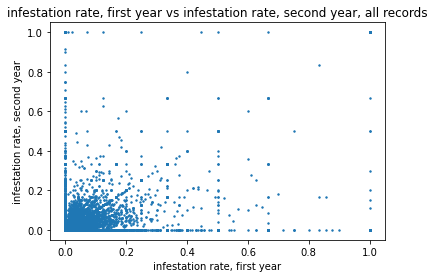

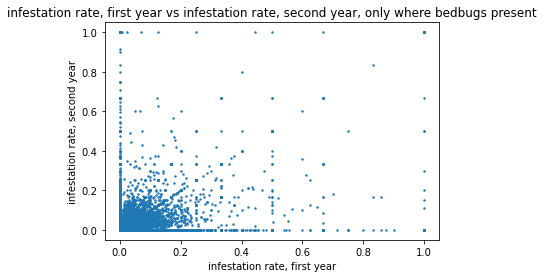

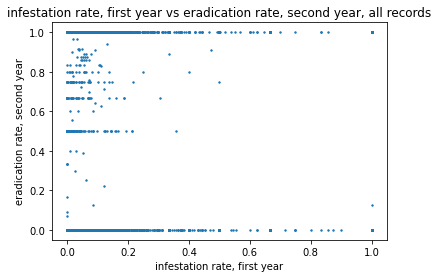

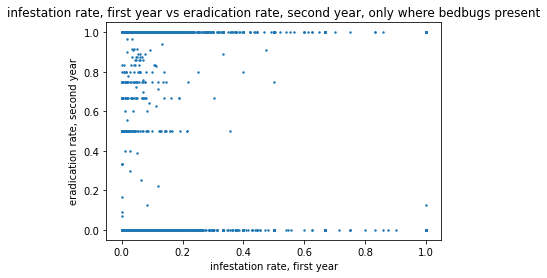

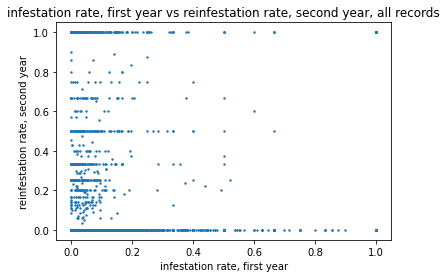

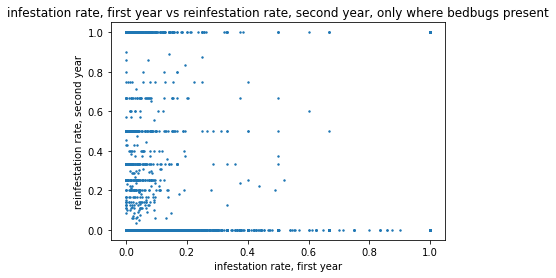

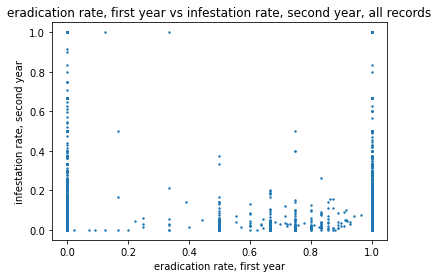

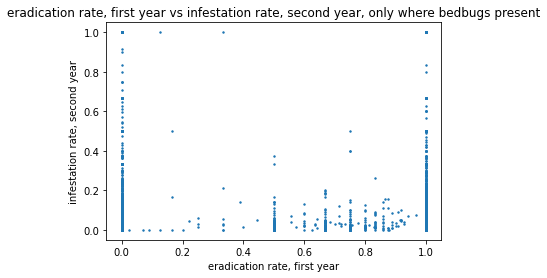

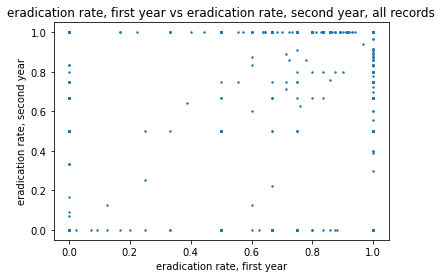

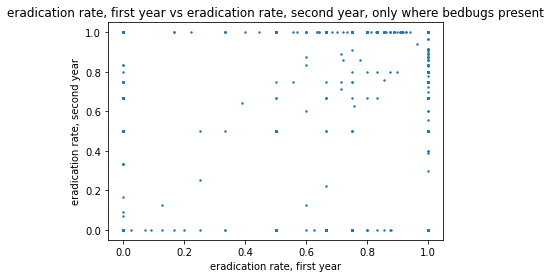

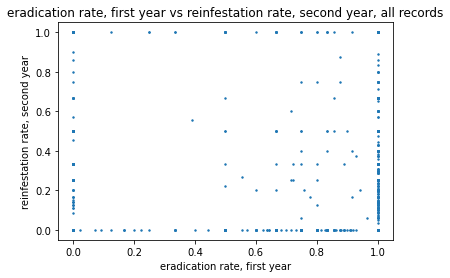

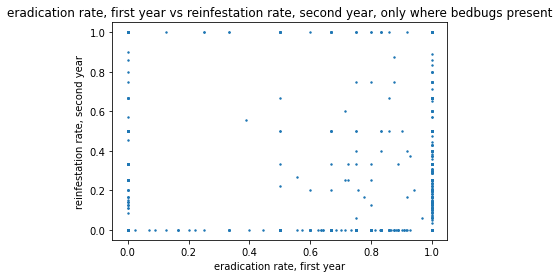

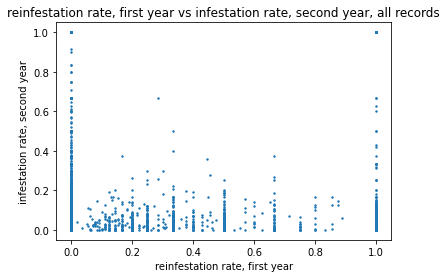

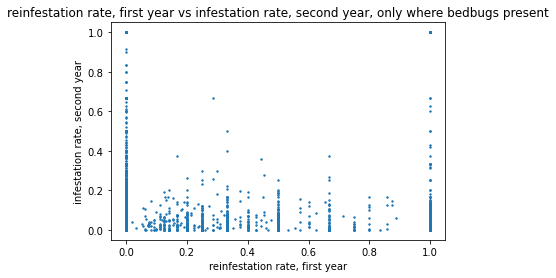

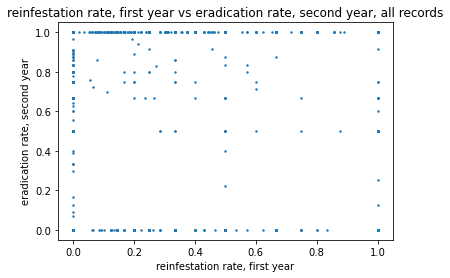

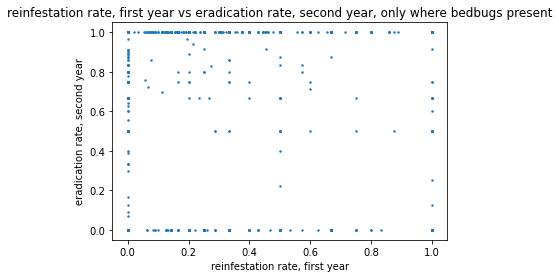

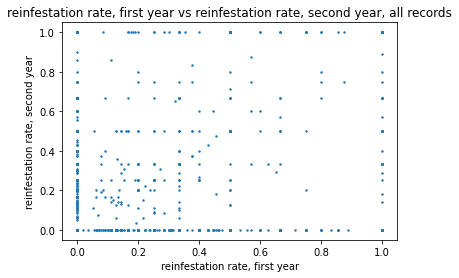

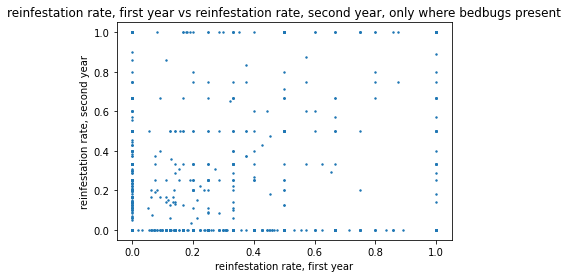

In [7]:
# make a dataframe consisting only of records for year pairs where the building had bedbugs present during the
# two years
df_final_nonzero = df_final.loc[~((df_final['infestation rate, first year'] == 0)&
                                  (df_final['infestation rate, second year']==0))]
print(f"{df_final.shape[0]} datapoints")
print(f"{df_final_nonzero.shape[0]} datapoints with bedbugs")

# make the scatter plots
col_base_names = ['infestation rate','eradication rate','reinfestation rate']
for x_col,y_col in itertools.product(col_base_names,col_base_names):
    horizontal_label = f"{x_col}, first year"
    vertical_label = f"{y_col}, second year"
    title = f"{horizontal_label} vs {vertical_label}"
    df_final.plot.scatter(x=horizontal_label, y=vertical_label,s=2, title=title+', all records')
    df_final_nonzero.plot.scatter(x=horizontal_label, y=vertical_label,s=2, title=title+', only where bedbugs present')

None

I don't see anything here worth pursuing. I will leave it there as far as this dataset goes, as I think I've got what I want out of it, namely a chance to practise/demonstrate some basic data skills.